# Detecting Tsunami-related Total Electron Content Anomalies in the Ionosphere with Convolutional Neural Networks

## Imports

In [1]:
import fastai
from fastai.vision.all import *
from hyperdash import monitor_cell, Experiment
import natsort
import os 

## Establish an Experiment

In [2]:
# Create an experiment with a model name, then autostart
exp = Experiment("Tsunami-related sTEC d/dt Anomaly Detection")

{ device_name: Tesla P100-SXM2-16GB }
{ data_path_train: /home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/train }
{ batch_size: 256 }
{ architecture: <function resnet34 at 0x7db96c63f268> }
{ learning_rate: 1e-05 }
{ parallel_gpus: False }
{ coverage_threshold: 0.9 }
{ epochs_max: 150 }


## Establishing CUDA device

In [3]:
# checking device number
assert torch.cuda.is_available()
index_device = torch.cuda.current_device()
device_name = exp.param("device_name", torch.cuda.get_device_name(index_device))

## Read Data

In [4]:
# set the data path 
data_path_train = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/train"
data_path_train = exp.param("data_path_train", data_path_train)
# data_path = "/u/scratch/s/stecproj/image_data/image_based/hawaii/train"

In [5]:
# set the batch size 
batch_size = 256
batch_size = exp.param("batch_size", batch_size)

In [6]:
# load in the data 
dls = ImageDataLoaders.from_folder(
    data_path_train, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=batch_size, #512, changed to 256 since my(Hamlin) GPU ran out of memory
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

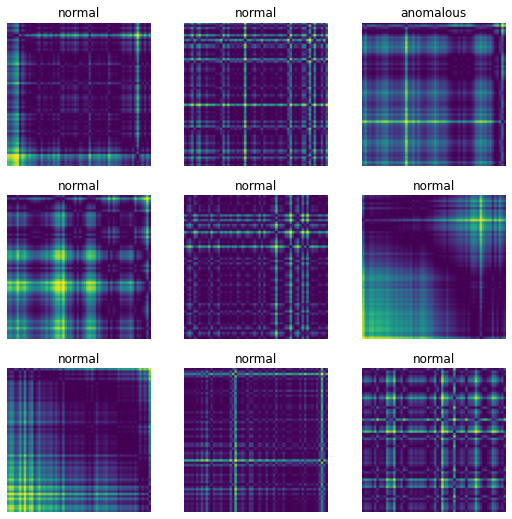

In [7]:
# show 9 sample images with correspond to our two labels in the dataset - normal and anomalous 
dls.show_batch()

In [8]:
# dls.dataset

In [9]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [10]:
# define the learner 
architecture = resnet34

learn = cnn_learner(
    dls, # data
    architecture, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

architecture = exp.param("architecture", architecture)

In [11]:
# learn.show_training_loop()

In [12]:
# for now, manually set the learning rate (automatic LR finders left for future work)
lr = 0.00001 # 0.00001 best result so far but not a given 
lr = exp.param("learning_rate", lr)

In [13]:
# parallel GPUs! Seems to work with squeezenet but not with resnet models (have not tried densenet, VGG or others)
parallel_gpus = False
# if torch.cuda.device_count() > 1:
#     parallel_gpus = True
#     learn.model = nn.DataParallel(learn.model)
parallel_gpus = exp.param("parallel_gpus", parallel_gpus)

## Metric functions

In [14]:
# set a threshold for calculating coverage
coverage_threshold = exp.param("coverage_threshold", 0.9)

In [15]:
def confusion_matrix_scores(cm: np.ndarray):
    """
    Returns a tuple of classification metrics according to
    the anomalous class as True Positive
    """
    accuracy = np.trace(cm)/np.sum(cm)
    total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
    pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
    precision = cm[0, 0] / total_anon
    recall = cm[0, 0] / pred_anon
    denom = (precision + recall) if (precision + recall) > 0 else 1
    F1 = 2 * precision * recall / denom
    return accuracy, precision, recall, F1

def calculating_coverage(predictions: torch.Tensor, targets: torch.Tensor, threhold: float):
    """
    Given a N-sized validation set,
    predictions is an N x 2 tensor since this is a binary classification problem
    targes is an N x 1 tensor where each targets[i] is the correct class
    
    returns 2 tuple of all coverages of each class
    """
    anomalous = np.where(targets == 0)
    normal = np.where(targets == 1)
    normal_predictions = predictions[normal, 1]
    anomalous_predictions = predictions[anomalous, 0]
    anom_coverage = np.average(anomalous_predictions > threshold)
    normal_coverage = np.average(normal_predictions > threshold)
    return anom_coverage, normal_coverage
    

In [16]:
# max number of epochs
epochs_max = exp.param("epochs_max", 150)

In [ ]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# set the parameters 
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 

# train the model 
learn.fit(
    epochs_max, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=5
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=10,
            min_delta=0.00001
        ),
        SaveModelCallback()
    ]
) 

# TODO: total training time 
# TODO: train loss, valid loss, error rate 


epoch,train_loss,valid_loss,error_rate,accuracy,time


In [ ]:
# plot the loss curve from model training
learn.recorder.plot_loss()

In [ ]:
learn.show_results(max_n=9)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [ ]:
# interpret results from test set
interp = ClassificationInterpretation.from_learner(learn) 
cm = interp.confusion_matrix()

results = confusion_matrix_scores(cm)
accuracy = exp.metric("accuracy", results[0])
precision = exp.metric("precision", results[1])
recall = exp.metric("recall", results[2])
F1_score = exp.metric("F1 Score", results[3])


# coverage calculation
predictions, targets = learn.get_preds() #by default uses validation set
anom_cov, normal_cov = calculating_coverage(predictions, targets, threshold)
anomaly_cov = exp.metric("anomaly coverage", anom_cov)
normal_cov = exp.metric("normal coverage", normal_cov)


## Export and Save the Model

In [ ]:
learn.export() # TODO: clean up export path and where model saves history, etc. 

## Real-World Experiment 

In [ ]:
# set path for the validation set of data 
data_path_validation = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/validation"
# data_path_validation = exp.param("data_path_validation", data_path_validation)

In [ ]:
# work in progress. For now, building out base functionality with a single set of data in the validation set 
test_path = data_path_validation + "/ahup__G08/unlabeled"

In [ ]:
# get all of the image paths in that directory 
image_files = [f for f in natsort.natsorted(os.listdir(test_path)) if ".jpg" in f]
image_files[0:10]

In [ ]:
# for each image, predict the classification 

# store the classification result in a time-indexed array that is T minutes long by W windows tall 

# show this as a heatmap to explain concept 

# use majority vote (as a baseline system) to assign anomaly versus normal assignments 
# note: other systems left for future work 

# 

In [ ]:
# DONE: holdout recall, precision, accuracy, f-score,  as well 


## End the Experiment

In [ ]:
# end the experiment 
exp.end()

# SCRATCH work
### To be deleted when requesting merge

In [ ]:
# clear cache and variables 
a = learn.get_preds()


In [ ]:
np.unique(np.argmax(a[0], axis=1))


In [ ]:
learn.metrics[1].__dict__

In [ ]:
dl = learn.dls[1]

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
arr

In [ ]:
z = interp.confusion_matrix()

In [ ]:
np.trace(z)/np.sum(z)

In [ ]:
np.sum(z[:, 0])

In [ ]:
learn.dls.loaders[1]

In [ ]:
dl

In [ ]:
cm = interp.confusion_matrix()
accuracy = np.trace(cm)/np.sum(cm)
total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
precision = cm[0, 0] / total_anon
recall = cm[0, 0] / pred_anon
denom = (precision + recall) if (precision + recall) > 0 else 1
F1 = 2 * precision * recall / denom

In [ ]:
F1

In [ ]:
cm

In [ ]:
dl = learn.dls[0]


In [ ]:
vars(dl)

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
print(normal[4460])
len(normal)


In [ ]:
PIL.Image.open(anomalies[29])
PIL.Image.open(anomalies[29])
PIL.Image.open(normal[4460])

In [ ]:
anomalies = get_image_files(data_path + "pat2__G08/labeled/anomalous/")
normal = get_image_files(data_path + "pat2__G08/labeled/normal/")

In [ ]:
v, t = learn.get_preds()


In [ ]:
np.where(np.array(t) == 1)


In [ ]:
a

In [ ]:
predictions, targets = learn.get_preds()
anomalous = np.where(targets == 0)
normal = np.where(targets == 1)
normal_predictions = predictions[normal, 1]
anomalous_predictions = predictions[anomalous, 0]


In [ ]:
normal_predictions.shape

In [ ]:
np.average(normal_predictions > 0.9)

In [ ]:
type(predictions)

In [ ]:
a, b = calculating_coverage(predictions, targets, 0.9)

In [ ]:
a


In [ ]:
B

In [ ]:
b